In [29]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# project specific libs
import os
import matplotlib.pyplot as plt

In [30]:
# set project path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/'

In [31]:
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)

# get first row for any future operations
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map = df_map.iloc[1:,]

# remove separate and together columns
df_map = df_map.drop(['Separate','Together'], axis=1)

# subset on useful columns
# TwinPair and Diagnosis are useful columns
df_map = df_map.loc[:,['TwinPair','Diagnosis']]

df_map.head()

,TwinPair,Diagnosis
#SampleID,,
500A.Fecal,T2,RA
501A.Fecal,T2,Unaffected
502A.Fecal,T3,RA
503A.Fecal,T3,Unaffected
504A.Fecal,T4,RA


In [32]:
# loop over L3, L6 and L7
# look at Clostridia and Bacteroidia 
Lx_to_df = {}
Lx_to_str = {
    'L3': 'level-3_10k',
    'L6': 'level-6_10k',
    'L7': 'level-7_10k'
}

for l in Lx_to_str:
    df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB/' + Lx_to_str[l] + '.csv',index_col=0)
    
    df_diag = df_otu['Diagnosis']
    otu_cols = []

    for c in list(df_otu.columns.values):
        if '__' in c:
            otu_cols.append(c)

    # subset on OTU
    df_otu = df_otu.loc[:,otu_cols]

    # divide by row sum (i.e. sample count) to normalize
    df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
    
    # save to dict
    Lx_to_df[l] = df_otu

df_otu.head()

,Unassigned;__;__;__;__;__;__,k__Archaea;__;__;__;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea;s__devanaterra,k__Archaea;p__Euryarchaeota;c__DSEG;o__ArcA07;f__;g__;s__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,...,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__Ellin517;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__R4-41B;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__auto67_4W;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__;s__,k__Bacteria;p__WPS-2;c__;o__;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;__;__;__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__;s__,k__Bacteria;p__ZB3;__;__;__;__;__,k__Bacteria;p__ZB3;c__BS119;o__;f__;g__;s__
index,,,,,,,,,,,,,,,,,,,,,
182A.Fecal,0.0,0.00000,0.000148,0.0,0.0,0.00000,0.001531,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000605,0.0,0.000594,0.0,0.0,0.0,0.000000
183A.Fecal,0.0,0.00012,0.000167,0.0,0.0,0.00047,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000375,0.0,0.000120,0.0,0.0,0.0,0.000000
500A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002825,0.0,0.000000,0.0,0.0,0.0,0.000000
501A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.001800,0.0,0.0,0.0,0.000000
502A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.002229


0.8134628971746307 0.4394903313705615


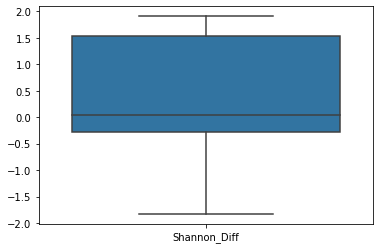

In [33]:
# paired shannon diversity difference from 0 
df_alpha = pd.read_csv(path + 'inputs/Qiime2_0_KB/shannon_metadata_10k.tsv', sep='\t', index_col=0)

# drop unnecessary rows and cols
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha.drop('Separate', axis=1)
df_alpha = df_alpha.drop(['Elutionbuffer1','Elutionbuffer2','blank'])

# get paired per twin pair
pair_to_diff = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    alpha_UA = float(df[df['Diagnosis'] == 'Unaffected']['shannon_entropy'].values)
    alpha_RA = float(df[df['Diagnosis'] == 'RA']['shannon_entropy'].values)
    pair_to_diff[p] = alpha_RA - alpha_UA

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['Shannon_Diff'])

# drop T1
df_paired_alpha = df_paired_alpha.drop('T1')

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha['Shannon_Diff'],popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=df_paired_alpha)

-0.6227105477161288 0.5367634090691689


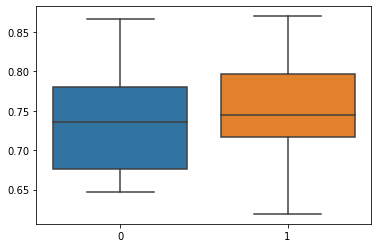

In [34]:
# paired beta div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
df_beta = pd.read_csv(path + 'inputs/Qiime2_0_KB/core_metrics_10k/unweighted_unifrac_distance_matrix.tsv', sep='\t', index_col=0)

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    id_UA = str(df[df['Diagnosis'] == 'Unaffected'].index.values[0])
    id_RA = str(df[df['Diagnosis'] == 'RA'].index.values[0])
    pair_to_ids[p] = (id_UA, id_RA)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_UA, id_RA]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Dist'])
df_paired_beta = df_paired_beta.drop('T1')

# grab inter RA distances
df_raw = pd.read_csv(path + 'inputs/Qiime2_0_KB/unweighted_raw_data.tsv', sep='\t', index_col=0)
df_RA = df_raw[df_raw['Group1'] == 'RA']
df_RA = df_RA[df_RA['Group2'] == 'RA']

# compare distances
inter_twin = df_paired_beta['Unweighted_Dist'].values
inter_RA = df_RA['Distance'].values

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
print(t, p)

sns.boxplot([inter_twin, inter_RA])

1.2693184558038249 0.24489831883583527


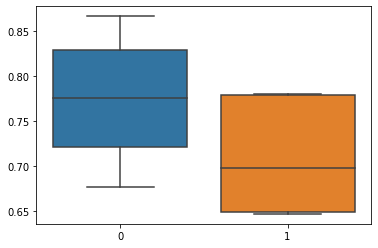

In [35]:
# investigate whether treated twins converge to unaffected twins

# manually input metadat afrom Patient_data_KB.xls
samp_to_MTX = {
    '500A.Fecal': 1,
    '502A.Fecal': 1,
    '504A.Fecal': 1,
    '506A.Fecal': 0,
    '508A.Fecal': 0,
    '510A.Fecal': 1,
    '512A.Fecal': 1,
    '514A.Fecal': 0, # previosuly, not currently
    '516A.Fecal': 0, # in 2012, not currently,
}

# get copy
df_meta = df_map.copy()

# replace with column dict per above
df_meta['MTX'] = df_meta.index.map(samp_to_MTX)

# replace nan with 0 i.e. untreated
df_meta['MTX'] = df_meta['MTX'].fillna(0) 

# create TwinPair to MTX mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_MTX = df['MTX'].to_dict()

# Things to ask
# 1. Do the twin pair distances decrease in treated vs untreated twins?
df_paired_beta['MTX'] = df_paired_beta.index.map(TP_to_MTX)

# compare distances
inter_untreated = df_paired_beta[df_paired_beta['MTX'] == 0]['Unweighted_Dist']
inter_treated = df_paired_beta[df_paired_beta['MTX'] == 1]['Unweighted_Dist']

t, p = scipy.stats.ttest_ind(inter_untreated, inter_treated)
print(t, p)

sns.boxplot([inter_untreated, inter_treated])


In [28]:
# get OTU table from RB
df1 = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/3_taxa.summary_qiime/all_by.sample/otu_table_RA.twins_16S_all_L3.txt', sep='\t', skiprows=1)
df1 = df1.set_index('#OTU ID').T
df1 = df1.drop(['182A.Fecal','183A.Fecal','Elutionbuffer1','Elutionbuffer2'])#
df1.to_csv(path + 'inputs/Qiime2_0_KB/otu_table_L3_Q1.csv')

for l in ['3','6','7']:
    # normalize OTU table and get Q2 version
    df2 = pd.read_csv(path + 'inputs/Qiime2_0_KB/level-' + l + '.csv', index_col=0)
    keep_cols = []
    for c in list(df2.columns.values):
        if '__' in c:
            keep_cols.append(c)
    df2 = df2[keep_cols]
    df2.to_csv(path + 'inputs/Qiime2_0_KB/counts_table_L' + l + '_Q2.csv')
    df2 = df2.div(df2.sum(axis=1), axis=0)
    df2.to_csv(path + 'inputs/Qiime2_0_KB/otu_table_L' + l + '_Q2.csv')
df2.head()


,Unassigned;__;__;__;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea;s__devanaterra,k__Archaea;p__Euryarchaeota;c__DSEG;o__ArcA07;f__;g__;s__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;s__,...,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__;s__,k__Bacteria;p__WPS-2;c__;o__;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;__;__;__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__;s__,k__Bacteria;p__ZB3;__;__;__;__;__,k__Bacteria;p__ZB3;c__BS119;o__;f__;g__;s__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__
index,,,,,,,,,,,,,,,,,,,,,
500A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.002474,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.002192,0.00000
501A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.000000,0.0,0.001672,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.00000
502A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.002134,0.0,0.000000,0.00000
503A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0024,0.0,0.001016,0.0,...,0.000000,0.0,0.000000,0.0,0.00226,0.0,0.000000,0.0,0.000000,0.00000
504A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.02143


In [15]:
# sklearn GMM DPGMM comparison
# https://scikit-learn.org/0.15/auto_examples/mixture/plot_gmm.html#example-mixture-plot-gmm-py

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

print(X)

[[ 0.68026725 -0.01634235]
 [ 3.80951844  0.79848348]
 [-1.6613724  -0.57766695]
 ...
 [-5.86152028  3.06842556]
 [-5.01893361  3.11090369]
 [-6.79933099  2.08232074]]


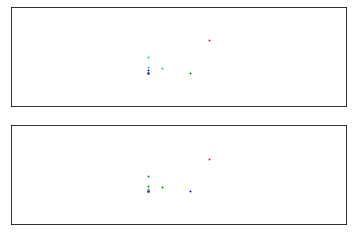

In [26]:
# still waiting on DMM to be released
http# s://scikit-learn.org/stable/modules/mixture.html#mixture
    
# set X to df2.values
X = df2.values

# Fit a mixture of Gaussians with EM using five components
# gmm = mixture.GMM(n_components=5, covariance_type='full')
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(X)

# Fit a Dirichlet process mixture of Gaussians using five components
#dpgmm = mixture.DPGMM(n_components=5, covariance_type='full')
#dpgmm.fit(X)
bgm = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full')
bgm.fit(X)

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

for i, (clf, title) in enumerate([(gmm, 'GMM'),
                                  (bgm, 'BGM')]):#(dpgmm, 'Dirichlet Process GMM')]):
    splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf.covariances_, color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        #angle = np.arctan(u[1] / u[0])
        #angle = 180 * angle / np.pi  # convert to degrees
        #ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        #ell.set_alpha(0.5)
        #splot.add_artist(ell)

    #plt.xlim(-10, 10)
    #plt.ylim(-3, 6)
    plt.xticks(())
    plt.yticks(())
    #plt.title(title)

plt.show()

    
    

In [ ]:
d